In [64]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import os
import csv
from datetime import datetime

In [65]:
# Defining the DQN model
class DQN(nn.Module):
    
    # Initialize the NN
    # input_dim refers to the state space size
    # output_dim refers to the Q values for each action in the given input state
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64) 
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    # defines the flow of input through the NN
    # relu --> Rectified Linear Unit, outputs the input directly if positive, else zero
    # Helps NN learn non-loinear relationsgips
    def forward(self, x):
        x = torch.relu(self.fc1(x)) # input x --> output_1 
        x = torch.relu(self.fc2(x)) # output_1 == input 2 --> output_2
        
        # no need for relu to get raw Q values for each actions
        return self.fc3(x) 

In [66]:
# Define the grid world environment
class GridWorld:
    def __init__(self, size, obstacles, bonus_points):
        # let size == n, where grid world is of size n by n
        # state to intialize grid with zeros
        # obstacles are coordinates that we want agent to learn to avoid
        # bonus is to incentivise and draw the agent towards a certain path 
        # collected_bonus is to not allow repeated collection of bonus
        # terminal state is a boolean for agent to end game
        # reset to reinitialize the environment for next epoch
        
        self.size = size
        self.obstacles = obstacles
        self.bonus_points = bonus_points
        self.collected_bonus = []
        self.state = np.zeros((size, size))
        self.terminal_state = (size-1, size-1)
        self.reset()
        
    def reset(self):
        self.agent_position = (0, 0)
        self.collected_bonus = [] 
        return self.agent_position
    
    # method to handles agent's interaction with the environment
    def step(self, action):
        x, y = self.agent_position
        
        # Move the agent based on the action
        if action == 0: # Move Up
            x = max(x - 1, 0)
        elif action == 1: # Move Down
            x = min(x + 1, self.size - 1)
        elif action == 2: # Move Left
            y = max(y - 1, 0)
        elif action == 3: # Move Right
            y = min(y + 1, self.size - 1)
            
        # Check for obstacles before updating position
        if (x, y) not in self.obstacles:
            self.agent_position = (x, y)
            
        # self.agent_position = (x, y)
        
        # Determine the reward
        if self.agent_position in self.obstacles:
            reward = -10.0 
        elif self.agent_position == self.terminal_state:
            reward = 100.0 
        elif self.agent_position in self.bonus_points and self.agent_position not in self.collected_bonus:
            # Reward based on specific bonus points
            if self.agent_position == (2, 4):
                reward = 70.0
            elif self.agent_position == (4, 1):
                reward = 0.01
            elif self.agent_position in [(9, 4), (3, 8)]:
                reward = 10.0
            elif self.agent_position == (8, 7):
                reward = 30.0
            self.collected_bonus.append(self.agent_position)
        else:
            reward = -5 # Small penalty for regular move
            
        done = self.agent_position == self.terminal_state
        return self.agent_position, reward, done
    
    # method to return current state as a numpy array to input to NN
    def get_state(self):
        return np.array(self.agent_position).flatten()
    
    # method to provide a grid snapshot of the environment as an array 
    def get_snapshot(self):
        snapshot = np.zeros((3, 3)) # creating a default 3 by 3 snapshot wrt agent's position, filled with zeroes
        x, y = self.agent_position
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                new_x, new_y = x + i, y + j
                if 0 <= new_x < self.size and 0 <= new_y < self.size:
                    if (new_x, new_y) in self.obstacles:
                        snapshot[i+1, j+1] = -1  # Obstacle
                    elif (new_x, new_y) in self.bonus_points and (new_x, new_y) not in self.collected_bonus:
                        snapshot[i+1, j+1] = 1  # Bonus point
                    elif (new_x, new_y) in self.terminal_state:
                        snapshot[i+1, j+1] = 5 # Terminal state
        return snapshot.flatten()

In [67]:
# Define the DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, snapshot_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        # state_dim is state space size for input into NN
        # action_dim is action space size to get output from NN
        # lr is learning rate for optimizer, controls how much to adjust model weights wrt loss
        # gamma is discount factor, determines how much future rewards are considered when updated Q values
        # epsilon is exploration rate --> decrease over time to exploit instead
        # epsilon_decay is rate that epsilon decreases after each epoch 
        # epsilon_min is a lowest bound so that agent continue to explore once in awhile
        # memory is a deque (double ended queue) to store past experiences w max size of 2000 
        ## --> experience replay buffer where minibatch is drawn for training
        # model to create instance of DQN NN 
        # optimizer --> Adam optimizer to update NN weights during training 
        # criterion is the loss function --> MSE to compute diff between predicted and target Q values
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.snapshot_dim = snapshot_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=2000)
        self.model = DQN(state_dim + snapshot_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
    # method to select action based on epsilon greedy strategy
    def choose_action(self, state, snapshot):
        # if random number generated is LTE epsilon, then pick random action (explore)
        combined_input = np.concatenate((state, snapshot)).astype(np.float32)
        
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        
        # else, exploit
        ## first convert state to tensor and adds a batch dimension
        ## pass to the model to get Q values
        ## selects action with highest Q value 
        state_tensor = torch.FloatTensor(combined_input).unsqueeze(0)
        q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()
    
    # method to store a transition into the experience replay buffer --> memory 
    ## each transition is a step/ interaction with the environment
    def store_transition(self, state, action, reward, next_state, done, snapshot, next_snapshot):
        combined_state = np.concatenate((state, snapshot)).astype(np.float32)
        combined_next_state = np.concatenate((next_state, next_snapshot)).astype(np.float32)
        self.memory.append((combined_state, action, reward, combined_next_state, done))
        
    # method to sample random experiences from memory to train the NN 
    def replay(self, batch_size):
        # to check if there are minimally equal number of experiences to batch size
        if len(self.memory) < batch_size:
            return 0
        
        batch = random.sample(self.memory, batch_size)
        
        # convert batch to tensors 
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # NN computes the Q values for the current states 
        ## gather() to extract Q values for the action taken in each state
        q_values = self.model(states).gather(1, actions)
        
        # compute target Q values based on bellman eqn 
        next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # compute loss as the MSE between predicted and target Q values
        loss = self.criterion(q_values, target_q_values)
        
        # update the model 
        ## backpropagate through backward()
        ## optimizer updated the network weights using step() 
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
    
    # method to decay epsilon after each epoch 
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [68]:
def plot_grid(env, path=[], actions=[]):
    size = env.size # square dimension of n by n 
    grid = np.ones((size, size, 3))  
    
    # Set obstacle color (Gray)
    for (x, y) in env.obstacles:
        grid[x, y] = [0.5, 0.5, 0.5]
        
    # Set bonus points color (Yellow)
    for (x, y) in env.bonus_points:
        if (x, y) not in env.collected_bonus:
            grid[x, y] = [1, 1, 0.0]  
        
    grid[0, 0] = [0, 0, 1]  # Start state (Blue)
    grid[size-1, size-1] = [1, 0, 0]  # Terminal state (Red)
    
    # Path taken by the agent (Green)
    for (x, y) in path:
        grid[x, y] = [0, 1, 0] 
    
    plt.figure(figsize=(5, 5))
    plt.imshow(grid)
    
    # Add grid lines and labels for whole numbers only
    plt.grid(True, which='major', color='black', linewidth=0.5)
    plt.xticks(np.arange(size) - 0.5 + 0.5, np.arange(size))  # Adjust x-axis tick positions by 0.5
    plt.yticks(np.arange(size) - 0.5 + 0.5, np.arange(size))  # Adjust y-axis tick positions by 0.5
    plt.gca().set_xticks(np.arange(size), minor=False)
    plt.gca().set_yticks(np.arange(size), minor=False)
    plt.gca().tick_params(which='minor', size=0)
    plt.gca().tick_params(which='major', size=10)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Grid World')
    
    # Invert the y-axis so that (0,0) is at the bottom left corner
    plt.gca().invert_yaxis()
    
    # Plot arrows indicating the direction of each action
    for i in range(1, len(path)):
        start_pos = path[i-1]
        end_pos = path[i]
        action = actions[i-1]
        
        dx = end_pos[1] - start_pos[1]
        dy = end_pos[0] - start_pos[0]
        
        plt.arrow(start_pos[1], start_pos[0], dx, dy, head_width=0.3, head_length=0.3, fc='blue', ec='blue')

    # Create legend for better understanding 
    blue_patch = patches.Patch(color='blue', label='Start State')
    red_patch = patches.Patch(color='red', label='Terminal State')
    green_patch = patches.Patch(color='green', label='Path Taken')
    gray_patch = patches.Patch(color='gray', label='Obstacle')
    yellow_patch = patches.Patch(color='yellow', label='Bonus Point')
    
    plt.legend(handles=[blue_patch, red_patch, green_patch, gray_patch, yellow_patch], loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

In [69]:
# method to train the agent in the environment for a total of n epochs
## batch_size is size of mini-batched used for experience replay during training
def train_dqn(env, agent, epochs, batch_size):
    rewards, losses, actions, epsilons = [], [], [], []
    
    # Variables to track convergence
    action_18_counter = 0  # Counts how many times exactly 18 actions were taken
    epoch_18_counter = 0   # Counts how many epochs had exactly 18 actions
    stop_threshold = 5     # Number of times the 18 action pattern needs to repeat
    min_epochs_with_pattern = 2  # Minimum number of epochs with this pattern
    
    # Check if the folder exists and create if not
    folder_name = "dqn_train_data"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
    # Create a CSV file with the current date and time
    file_name = f"{folder_name}/data_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Reward", "Loss", "Actions", "Epsilon"])
    
    # Plot the initial grid
    plot_grid(env)
    
    # for every new epoch, reset the environment and agent
    ## reset the variable checkers, path taken and number of actions taken to reach terminal state 
    for epoch in range(epochs):
        state = env.reset()
        total_reward, total_loss, total_actions = 0, 0, 0
        done = False
        path = [state]
        epoch_actions = []
        
        # agent will continue to interact w environment as long as state != terminal state
        while not done:
            snapshot = env.get_snapshot()  # Get initial snapshot before taking action
            action = agent.choose_action(state, snapshot) # choose action based on epsilon greedy strategy
            next_state, reward, done = env.step(action)
            next_snapshot = env.get_snapshot()  # Get snapshot after taking the action
            
            agent.store_transition(state, action, reward, next_state, done, snapshot, next_snapshot) # store experience in memory 
            state = next_state # updates the current state 
            path.append(state) # tracks the state as part of path taken
            epoch_actions.append(action) # tracks the actions taken


            # trains the DQN NN using a mini-batch from memory 
            ## replay() computes loss and perform backpropagation to minimize this loss 
            loss = agent.replay(batch_size) 
            
            total_reward += reward
            total_loss += loss
            total_actions += 1

        agent.update_epsilon() # decrease epsilon after each epoch
        
        # Increment the counter if exactly 18 actions were taken
        if (total_actions == 18 and total_reward == 125):
            action_18_counter += 1  # Increment the consecutive counter
        else:
            action_18_counter = 0  # Reset the consecutive counter if the pattern breaks

        # Increment epoch_18_counter if the consecutive pattern was repeated enough
        if action_18_counter >= stop_threshold:
            epoch_18_counter += 1
            action_18_counter = 0  # Reset the consecutive counter for next streak
        
        rewards.append(total_reward)
        losses.append(total_loss)
        actions.append(total_actions)
        epsilons.append(agent.epsilon)

        # Write data to CSV file
        with open(file_name, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, total_reward, total_loss, total_actions, agent.epsilon])

        print(f"Epoch: {epoch+1}/{epochs}, Reward: {total_reward}, Loss: {total_loss}, Actions: {total_actions}, Epsilon: {agent.epsilon}")
                         
        # Plot the grid with the path taken by the agent 
        if (epoch % 50 == 0):
            plot_grid(env, path, epoch_actions)
        
        # Stop training if the pattern has been repeated enough times
        if epoch_18_counter >= min_epochs_with_pattern:
            print(f"Training stopped at epoch {epoch+1} as the action pattern of 18 actions repeated {min_epochs_with_pattern} times.")
            break

    return file_name

In [70]:
# method to read date from csv file to plot the results
def plot_results_from_csv(file_name):
    epochs, rewards, losses, actions = [], [], [], []

    # Read data from CSV file
    with open(file_name, mode='r') as file:
        reader = csv.DictReader(file) # read as dictionary where column names are keys
        for row in reader:
            epochs.append(int(row["Epoch"]))
            rewards.append(float(row["Reward"]))
            losses.append(float(row["Loss"]))
            actions.append(float(row["Actions"]))

    # Plotting the data in the csv file
    plt.figure(figsize=(15,5)) # accomodate multiple plots 

    # Plot Rewards (Y) against epochs (X)
    plt.subplot(1, 3, 1)
    plt.plot(epochs, rewards)
    plt.title('Rewards per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')

    # Plot Losses (Y) against epochs (X)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, losses)
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')

    # Plot Actions (Y) against epochs (X)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, actions)
    plt.title('Actions per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Total Actions')

    plt.show()

In [71]:
# method to read date from csv file to plot the results
def plot_results_from_csv(file_name):
    epochs, rewards, losses, actions = [], [], [], []

    # Read data from CSV file
    with open(file_name, mode='r') as file:
        reader = csv.DictReader(file) # read as dictionary where column names are keys
        for row in reader:
            epochs.append(int(row["Epoch"]))
            rewards.append(float(row["Reward"]))
            losses.append(float(row["Loss"]))
            actions.append(float(row["Actions"]))

    # Plotting the data in the csv file
    plt.figure(figsize=(15,5)) # accomodate multiple plots 

    # Plot Rewards (Y) against epochs (X)
    plt.subplot(1, 3, 1)
    plt.plot(epochs, rewards)
    plt.title('Rewards per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Total Reward')

    # Plot Losses (Y) against epochs (X)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, losses)
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')

    # Plot Actions (Y) against epochs (X)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, actions)
    plt.title('Actions per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Total Actions')

    plt.show()

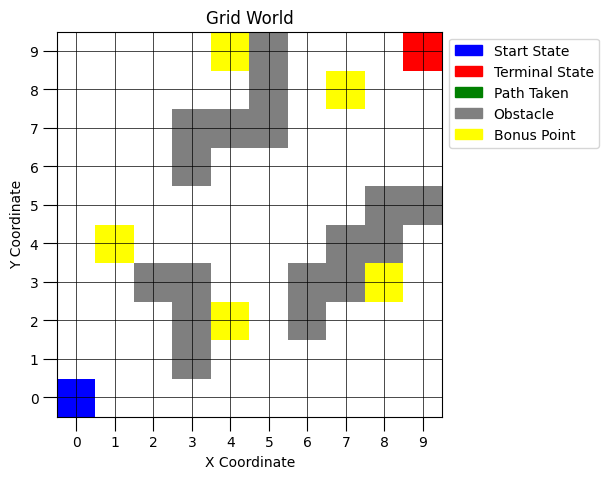

Epoch: 1/1000, Reward: -830.0, Loss: 5011.937498092651, Actions: 209, Epsilon: 0.995


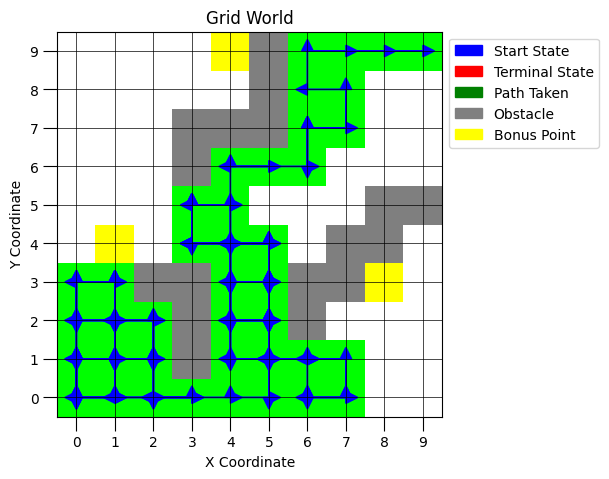

Epoch: 2/1000, Reward: -7354.99, Loss: 43348.64510035515, Actions: 1521, Epsilon: 0.990025
Epoch: 3/1000, Reward: -859.99, Loss: 3232.518253326416, Actions: 216, Epsilon: 0.985074875
Epoch: 4/1000, Reward: -464.99, Loss: 1420.8336917161942, Actions: 137, Epsilon: 0.9801495006250001
Epoch: 5/1000, Reward: -2354.99, Loss: 7052.028275251389, Actions: 518, Epsilon: 0.9752487531218751
Epoch: 6/1000, Reward: -140.0, Loss: 683.6656079292297, Actions: 64, Epsilon: 0.9703725093562657
Epoch: 7/1000, Reward: -2109.99, Loss: 6139.824609518051, Actions: 469, Epsilon: 0.9655206468094844
Epoch: 8/1000, Reward: -3875.0, Loss: 12727.476585507393, Actions: 814, Epsilon: 0.960693043575437
Epoch: 9/1000, Reward: -7919.99, Loss: 15388.478539019823, Actions: 1634, Epsilon: 0.9558895783575597
Epoch: 10/1000, Reward: -6584.99, Loss: 7871.1431203484535, Actions: 1364, Epsilon: 0.9511101304657719
Epoch: 11/1000, Reward: -245.0, Loss: 609.2808867990971, Actions: 92, Epsilon: 0.946354579813443
Epoch: 12/1000, Rew

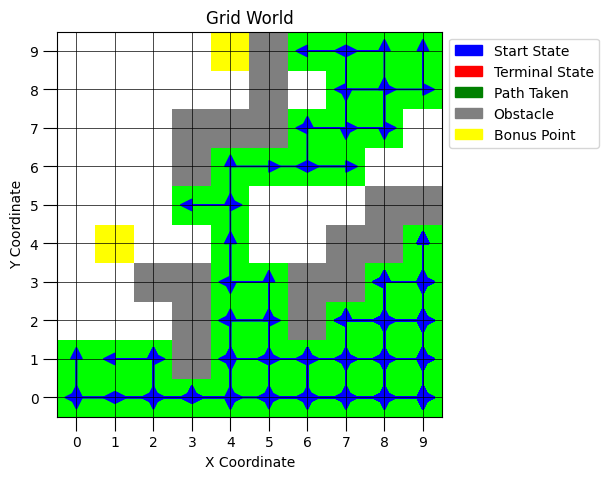

Epoch: 52/1000, Reward: -4770.0, Loss: 8900.098053514957, Actions: 1000, Epsilon: 0.7705488893118823
Epoch: 53/1000, Reward: -12045.0, Loss: 20956.88032913208, Actions: 2455, Epsilon: 0.7666961448653229
Epoch: 54/1000, Reward: -734.99, Loss: 584.2473531663418, Actions: 176, Epsilon: 0.7628626641409962
Epoch: 55/1000, Reward: -4705.0, Loss: 3403.1600705087185, Actions: 972, Epsilon: 0.7590483508202912
Epoch: 56/1000, Reward: -289.99, Loss: 305.345538020134, Actions: 87, Epsilon: 0.7552531090661897
Epoch: 57/1000, Reward: -240.0, Loss: 381.4208123385906, Actions: 84, Epsilon: 0.7514768435208588
Epoch: 58/1000, Reward: -6899.99, Loss: 8634.762290894985, Actions: 1412, Epsilon: 0.7477194593032545
Epoch: 59/1000, Reward: -1334.99, Loss: 2091.846034795046, Actions: 314, Epsilon: 0.7439808620067382
Epoch: 60/1000, Reward: -2895.0, Loss: 4205.135238528252, Actions: 625, Epsilon: 0.7402609576967045
Epoch: 61/1000, Reward: -215.0, Loss: 539.5271685123444, Actions: 71, Epsilon: 0.736559652908221


KeyboardInterrupt: 

In [72]:
# Initialize environment and agent
obstacles = [(1, 3), (2, 3), (2, 6), (3, 2), (3, 3), (3, 6), (3, 7), (4, 7), (4, 8), (5, 8), (5, 9), (6, 3), (7, 3), (7, 4), (7, 5), (8, 5), (9, 5)]
bonus_points = [(2, 4), (3, 8), (4, 1), (8, 7), (9, 4)]
env = GridWorld(size=10, obstacles=obstacles, bonus_points=bonus_points)
agent = DQNAgent(state_dim=2, action_dim=4, snapshot_dim=9)

# Train the model and get the file name
file_name = train_dqn(env, agent, epochs=1000, batch_size=32)

# Plot the results from the CSV file
plot_results_from_csv(file_name)